## Generate Random Image to test the Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
IMG_SHAPE = (32, 32, 3)
my_generator = np.random.default_rng()

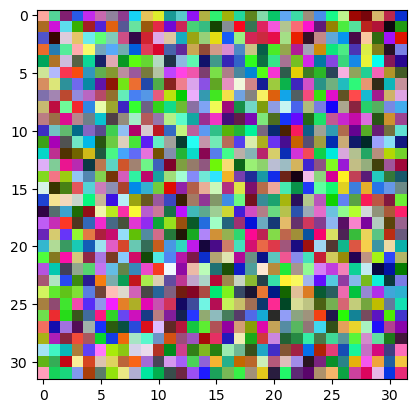

In [10]:
rand_img = my_generator.integers(0, 255+1, IMG_SHAPE)
plt.imshow(rand_img)

## MLFLOW

In [38]:
# https://mlflow.org/docs/latest/getting-started/logging-first-model/notebooks/logging-first-model.html

In [1]:
import mlflow
from mlflow import MlflowClient

In [2]:
mlflow.login()
client = MlflowClient(tracking_uri="databricks")

2024/06/09 10:29:39 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [3]:
all_experiments = client.search_experiments()

In [4]:
print(all_experiments)

[<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3258463043345582', creation_time=1717885811916, experiment_id='3258463043345582', last_update_time=1717885935083, lifecycle_stage='active', name='/Frames', tags={'mlflow.experiment.sourceName': '/Frames',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'micasadmail@gmail.com',
 'mlflow.ownerId': '1279350886999606'}>]


In [10]:
default_experiment = [
    {"name": experiment.name, "lifecycle_stage": experiment.lifecycle_stage}
    for experiment in all_experiments
    if experiment.name == "/Frames"
][0]

In [11]:
print(default_experiment)

{'name': '/Frames', 'lifecycle_stage': 'active'}


In [13]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the grocery forecasting project. "
    "This experiment contains the produce models for apples."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "grocery-forecasting",
    "store_dept": "produce",
    "team": "stores-ml",
    "project_quarter": "Q3-2023",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
produce_apples_experiment = client.create_experiment(
    name="/Apple_Models", tags=experiment_tags
)

In [14]:
# Use search_experiments() to search on the project_name tag key

apples_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'grocery-forecasting'"
)

print(vars(apples_experiment[0]))

{'_experiment_id': '1842337668510547', '_name': '/Apple_Models', '_artifact_location': 'dbfs:/databricks/mlflow-tracking/1842337668510547', '_lifecycle_stage': 'active', '_tags': {'mlflow.experiment.sourceName': '/Apple_Models', 'mlflow.ownerId': '1279350886999606', 'mlflow.ownerEmail': 'micasadmail@gmail.com', 'mlflow.experimentType': 'MLFLOW_EXPERIMENT', 'mlflow.note.content': 'This is the grocery forecasting project. This experiment contains the produce models for apples.', 'project_name': 'grocery-forecasting', 'project_quarter': 'Q3-2023', 'store_dept': 'produce', 'team': 'stores-ml'}, '_creation_time': 1717922141475, '_last_update_time': 1717922141475}


In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [16]:
def generate_apple_sales_data_with_promo_adjustment(
    base_demand: int = 1000, n_rows: int = 5000
):
    """
    Generates a synthetic dataset for predicting apple sales demand with seasonality
    and inflation.

    This function creates a pandas DataFrame with features relevant to apple sales.
    The features include date, average_temperature, rainfall, weekend flag, holiday flag,
    promotional flag, price_per_kg, and the previous day's demand. The target variable,
    'demand', is generated based on a combination of these features with some added noise.

    Args:
        base_demand (int, optional): Base demand for apples. Defaults to 1000.
        n_rows (int, optional): Number of rows (days) of data to generate. Defaults to 5000.

    Returns:
        pd.DataFrame: DataFrame with features and target variable for apple sales prediction.

    Example:
        >>> df = generate_apple_sales_data_with_seasonality(base_demand=1200, n_rows=6000)
        >>> df.head()
    """

    # Set seed for reproducibility
    np.random.seed(9999)

    # Create date range
    dates = [datetime.now() - timedelta(days=i) for i in range(n_rows)]
    dates.reverse()

    # Generate features
    df = pd.DataFrame(
        {
            "date": dates,
            "average_temperature": np.random.uniform(10, 35, n_rows),
            "rainfall": np.random.exponential(5, n_rows),
            "weekend": [(date.weekday() >= 5) * 1 for date in dates],
            "holiday": np.random.choice([0, 1], n_rows, p=[0.97, 0.03]),
            "price_per_kg": np.random.uniform(0.5, 3, n_rows),
            "month": [date.month for date in dates],
        }
    )

    # Introduce inflation over time (years)
    df["inflation_multiplier"] = (
        1 + (df["date"].dt.year - df["date"].dt.year.min()) * 0.03
    )

    # Incorporate seasonality due to apple harvests
    df["harvest_effect"] = np.sin(2 * np.pi * (df["month"] - 3) / 12) + np.sin(
        2 * np.pi * (df["month"] - 9) / 12
    )

    # Modify the price_per_kg based on harvest effect
    df["price_per_kg"] = df["price_per_kg"] - df["harvest_effect"] * 0.5

    # Adjust promo periods to coincide with periods lagging peak harvest by 1 month
    peak_months = [4, 10]  # months following the peak availability
    df["promo"] = np.where(
        df["month"].isin(peak_months),
        1,
        np.random.choice([0, 1], n_rows, p=[0.85, 0.15]),
    )

    # Generate target variable based on features
    base_price_effect = -df["price_per_kg"] * 50
    seasonality_effect = df["harvest_effect"] * 50
    promo_effect = df["promo"] * 200

    df["demand"] = (
        base_demand
        + base_price_effect
        + seasonality_effect
        + promo_effect
        + df["weekend"] * 300
        + np.random.normal(0, 50, n_rows)
    ) * df[
        "inflation_multiplier"
    ]  # adding random noise

    # Add previous day's demand
    df["previous_days_demand"] = df["demand"].shift(1)
    df["previous_days_demand"].fillna(
        method="bfill", inplace=True
    )  # fill the first row

    # Drop temporary columns
    df.drop(columns=["inflation_multiplier", "harvest_effect", "month"], inplace=True)

    return df

In [ ]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:
mlflow.set_tracking_uri("databricks")

In [19]:
# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
apple_experiment = mlflow.set_experiment("/Apple_Models")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "apples_rf_test"

# Define an artifact path that the model will be saved to.
artifact_path = "rf_apples"

In [21]:
1_000

1000

In [24]:
# Generate the dataset!

data = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=1_000)

data[-20:]

C:\Users\mic-c\AppData\Local\Temp\ipykernel_9424\517260083.py:84: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["previous_days_demand"].fillna(


,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand
980,2024-05-21 10:58:25.824575,34.130183,1.454065,0,0,1.449177,0,999.306290,1029.418398
981,2024-05-22 10:58:25.824575,32.353643,9.462859,0,0,2.856503,0,842.129427,999.306290
982,2024-05-23 10:58:25.824575,18.816833,0.391470,0,0,1.326429,0,990.616709,842.129427
983,2024-05-24 10:58:25.824575,34.533012,2.120477,0,0,0.970131,0,1068.802075,990.616709
984,2024-05-25 10:58:25.824575,23.057202,2.365705,1,0,1.049931,0,1346.486305,1068.802075
985,2024-05-26 10:58:25.824575,34.810165,3.089005,1,0,2.035149,0,1329.564672,1346.486305
986,2024-05-27 10:58:25.824575,29.208905,3.673292,0,0,2.518098,0,1086.143402,1329.564672
987,2024-05-28 10:58:25.824575,16.428676,4.077782,0,0,1.268979,0,1093.207186,1086.143402
988,2024-05-29 10:58:25.824575,32.067512,2.734454,0,0,0.762317,0,1069.939894,1093.207186
989,2024-05-30 10:58:25.824575,31.938203,13.883486,0,0,1.153301,0,994.409540,1069.939894


In [25]:
# Split the data into features and target and drop irrelevant date field and target field
X = data.drop(columns=["date", "demand"])
y = data["demand"]

In [27]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 888,
}

In [29]:
# Train the RandomForestRegressor
rf = RandomForestRegressor(**params)

In [30]:
# Fit the model on the training data
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=4, min_samples_split=10,
                      random_state=888)

In [31]:
# Predict on the validation set
y_pred = rf.predict(X_val)

In [32]:
# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

In [33]:
# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

In [37]:
# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(
        sk_model=rf, input_example=X_val, artifact_path=artifact_path
    )

C:\Users\mic-c\anaconda3\envs\opencv_contrib_env\lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\mic-c\anaconda3\envs\opencv_contrib_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Uploading artifacts:   0%|          | 0/10 [00:00<?, ?it/s]

2024/06/09 11:02:44 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


## Tensorboard Get Started

In [47]:
import tensorflow as tf
import datetime
import os
from pathlib import Path

In [56]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [57]:
# reduce dataset to speed train
x_train = x_train[:int(len(x_train) * 0.2)]
y_train = y_train[:int(len(y_train) * 0.2)]

x_test = x_test[:int(len(x_test) * 0.2)]
y_test = y_test[:int(len(y_test) * 0.2)]

In [58]:
x_train, x_test = x_train / 255.0, x_test / 255.0


def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='layers_flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='layers_dense'),
    tf.keras.layers.Dropout(0.2, name='layers_dropout'),
    tf.keras.layers.Dense(10, activation='softmax', name='layers_dense_2')
  ])

In [59]:
TENSORBOARD_LOG_PATH = "logs/fit/"
model_name = 'VGG16_Imagenet'
time_now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [60]:
log_dir = Path(TENSORBOARD_LOG_PATH, model_name, time_now)

In [61]:
log_dir

WindowsPath('logs/fit/VGG16_Imagenet/20240608-164209')

In [62]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/5
375/375 [==============================] - 4s 10ms/step - loss: 3.1266 - accuracy: 0.5474 - val_loss: 1.5355 - val_accuracy: 0.4710
Epoch 2/5
375/375 [==============================] - 3s 9ms/step - loss: 1.5442 - accuracy: 0.4745 - val_loss: 1.5970 - val_accuracy: 0.5110
Epoch 3/5
375/375 [==============================] - 3s 9ms/step - loss: 1.6762 - accuracy: 0.4417 - val_loss: 1.9769 - val_accuracy: 0.3985
Epoch 4/5
375/375 [==============================] - 3s 9ms/step - loss: 1.8175 - accuracy: 0.3480 - val_loss: 1.7610 - val_accuracy: 0.4030
Epoch 5/5
375/375 [==============================] - 4s 9ms/step - loss: 1.7248 - accuracy: 0.3612 - val_loss: 1.7728 - val_accuracy: 0.4505


## Dataframe from json - Testing Report

In [1]:
import pandas as pd

In [5]:
json_path = 'Models/Frame/VGG16/Run_1/VGG16_report.csv'

In [6]:
pd.read_csv(json_path)

,emotion,precision,recall,f1-score,support
0,angry,0.537210,0.435651,0.481130,2502.0
1,calm,0.645076,0.384252,0.481619,2540.0
2,disgust,0.699816,0.594447,0.642842,2557.0
3,fearful,0.330964,0.549388,0.413079,2288.0
4,happy,0.443645,0.748651,0.557136,2224.0
5,sad,0.322862,0.353323,0.337407,2618.0
6,surprised,0.234072,0.079604,0.118805,2123.0


---

## Check frames / flow differences

In [26]:
import csv
from pathlib import Path
import pandas as pd
import constants as c
import utils
import cv2

In [11]:
# Read frame dataset
df_extended = pd.read_csv(Path(c.csv_path, 'dataset_extended.csv'))

In [12]:
df_extended.head(2)

,path,filename,frames,actor,modality,channel,intensity,statement,repetition,emotion
0,Datasets\RAVDESS\Video_Speech_Actor_01\Actor_01,01-01-01-01-01-01-01.mp4,99,1,1,1,1,1,1,1
1,Datasets\RAVDESS\Video_Speech_Actor_01\Actor_01,01-01-01-01-01-02-01.mp4,100,1,1,1,1,1,2,1


In [53]:
frames_folders = Path(c.frames_path).glob('*')
flows_folders = Path(c.flows_path, 'TVL1').glob('*')
for em_fr, em_fl in zip(frames_folders, flows_folders):
    ac_fr = em_fr.glob('*')
    ac_fl = em_fl.glob('*')
    for a, b in zip(ac_fr, ac_fl):
        a_len = len(list(a.glob('*.jpg')))
        b_len = len(list(b.glob('*.jpg')))
        diff = a_len - b_len
        if (diff == 0):
            print()
            print(a, b)
            print(a_len, b_len, diff)


Generated\Frames\angry\02 Generated\Flows\TVL1\angry\02
914 914 0

Generated\Frames\angry\03 Generated\Flows\TVL1\angry\03
989 989 0

Generated\Frames\angry\04 Generated\Flows\TVL1\angry\04
882 882 0

Generated\Frames\angry\05 Generated\Flows\TVL1\angry\05
903 903 0

Generated\Frames\angry\07 Generated\Flows\TVL1\angry\07
944 944 0

Generated\Frames\angry\08 Generated\Flows\TVL1\angry\08
873 873 0

Generated\Frames\angry\10 Generated\Flows\TVL1\angry\10
975 975 0

Generated\Frames\angry\11 Generated\Flows\TVL1\angry\11
876 876 0

Generated\Frames\angry\13 Generated\Flows\TVL1\angry\13
880 880 0

Generated\Frames\angry\16 Generated\Flows\TVL1\angry\16
932 932 0

Generated\Frames\angry\18 Generated\Flows\TVL1\angry\18
916 916 0

Generated\Frames\angry\20 Generated\Flows\TVL1\angry\20
909 909 0

Generated\Frames\angry\21 Generated\Flows\TVL1\angry\21
991 991 0

Generated\Frames\angry\22 Generated\Flows\TVL1\angry\22
938 938 0

Generated\Frames\angry\23 Generated\Flows\TVL1\angry\23
786 7

In [37]:
vidcap = cv2.VideoCapture('Datasets/RAVDESS/Video_Speech_Actor_01/Actor_01/01-01-01-01-01-02-01.mp4')
print('calc_frames', vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

frames = 0
while (True):
    ret, frame = vidcap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frames += 1 
    cv2.imshow('Frame', frame)
    k = cv2.waitKey(30) & 0xff
    if k == 27:  # ESC
        break

vidcap.release()
cv2.destroyAllWindows()

print('eff_frames', frames)

calc_frames 100.0
No frames grabbed!
eff_frames 99


In [24]:
videos = utils.video_search(df_extended)
videos_number = len(videos)
videos_frame_sum = videos['frames'].sum()

print(videos_number, videos_frame_sum, videos_frame_sum-videos_number)

1440 159702 158262


---

## Models results from files

In [4]:
import csv
from pathlib import Path
import pandas as pd

In [6]:
# Print Best Results

res = pd.read_csv(Path('Models/Speech/models.csv'), index_col=False, sep=';')
res

,Model Name,Epochs,% Validation,% Test set,Train loss,Train accuracy,Val loss,Val accuracy,Test loss,Test accuracy,Mean epoch time,Note
0,example_model,5,8.88,13.33,1.6351945638656615,0.3838541626930237,1.6237019300460815,0.4015625,1.463215,0.487500,1.918471,NaN
1,example_model,5,8.88,13.33,1.6590404748916625,0.3670138895511627,1.6569401264190673,0.3734375,1.531938,0.418750,2.532693,NaN
2,example_model,20,8.88,13.33,0.9915891662240028,0.6389973908662796,1.369975559413433,0.513671875,1.393803,0.568750,1.854545,NaN
3,tensorflow_tutorial_model,20,8.88,13.33,0.9444216251373291,0.6595486119389534,1.363307672739029,0.5265625,1.397516,0.600000,4.117070,NaN
4,tensorflow_tutorial_model,20,8.88,13.33,"[1.9859237670898438, 1.7848432064056396, 1.638...","[0.2361111044883728, 0.3315972089767456, 0.382...","[1.8243215084075928, 1.7073079347610474, 1.602...","[0.2734375, 0.3125, 0.40625, 0.484375, 0.52343...",1.287407,0.568750,4.486525,NaN
5,tensorflow_tutorial_model\Run_1,20,8.88,13.33,"[1.9859237670898438, 1.7848432064056396, 1.638...","[0.2361111044883728, 0.3315972089767456, 0.382...","[1.8243215084075928, 1.7073079347610474, 1.602...","[0.2734375, 0.3125, 0.40625, 0.484375, 0.52343...",1.287407,0.568750,4.486525,NaN
6,tensorflow_tutorial_model\Run_1,20,8.88,13.33,1.0400293786078691,0.6151801142841578,1.3607724383473396,0.5107421875,1.287407,0.568750,4.486525,NaN
7,tensorflow_tutorial_model\Run_2,30,8.88,13.33,0.8392242335460403,0.6931423646482554,1.4109554453329607,0.4893465909090909,1.388468,0.606250,8.590524,NaN
8,tensorflow_tutorial_model\Run_3,30,8.88,13.33,0.9868511948734522,0.6416015662252903,1.3898383527994156,0.51416015625,1.432737,0.593750,16.102214,NaN
9,medium_example_model\Run_1,30,8.88,13.33,1.4314823746681213,0.5725549745062987,1.4679578244686127,0.4739583333333333,1.616114,0.450000,1.344759,NaN


---

## GridSearch subset

---

## Save dataframe with only frames

---

## Save spectogram to image

In [ ]:
# load audio. Using example from librosa
path = librosa.example('brahms')
y, sr = librosa.load(path, sr=None)
output_filename = Path('out2.png')

# extract a fixed length window
start_sample = 0  # starting at beginning
length_samples = 200 * HOP_LENGTH
window = y[start_sample:start_sample+length_samples]

spec = ut_au.get_librosa_spectrogram(y)
# ut_au.plot_librosa_spectrogram(spec)

mel_spec = ut_au.get_librosa_mel_spectrogram(
    y=window, sr=sr, hop_length=HOP_LENGTH, n_mels=N_MELS
)

ut_au.plot_librosa_spectrogram(
    mel_spec, ax=None, sr=sr, hop_length=HOP_LENGTH, y_axis='mel'
)

img = ut_au.spec_to_image(mel_spec)
cv2.imwrite(str(output_filename), img)

In [32]:
# %matplotlib qt
%matplotlib inline
# open plt in windows and not inline
# https://stackoverflow.com/a/43101480


def plot_spectrogram(y, ax=None, sr=SAMPLE_RATE, n_fft=FFT_LENGTH,
                     hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,
                     x_axis='time', y_axis='linear', yticks=None):

    librosa.display.specshow(y,
                             sr=sr,
                             hop_length=hop_length,
                             n_fft=n_fft,
                             win_length=win_length,
                             x_axis=x_axis,
                             y_axis=y_axis,
                             ax=ax)
#    if yticks is not None:
#        plt.yticks(yticks)
#    plt.colorbar(format='%+2.f dB')

    # redraw the canvas
    # if(show_in_cv2):
    #    fig.canvas.draw()
    #
    #    # convert canvas to image
    #    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    #    img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    #
    #    # img is rgb, convert to opencv's default bgr
    #    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    #
    #
    #    # display image with opencv or any operation you like
    #    cv2.imshow("plot",img)
    #    k = cv2.waitKey(2300) & 0xff
    #
    #    cv2.destroyAllWindows()


In [58]:
def spectrogram_image(y, sr, out, hop_length, n_mels):
    # https://stackoverflow.com/a/57204349
    mels = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, n_fft=hop_length*2, hop_length=hop_length
    )
    mels = np.log(mels + 1e-9)  # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = utils.scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0)  # put low frequencies at the bottom in image
    img = 255 - img  # invert. make black==more energy

    cv2.imwrite(out, img)

In [79]:
librosa_examples = [
    'brahms', 'choice', 'humpback', 'libri1',
    'libri2', 'libri3', 'nutcracker', 'pistachio', 'robin',
    'sweetwaltz', 'trumpet', 'vibeace'
]

# settings
hop_length = 512  # number of samples per time-step in spectrogram
n_mels = 128  # number of bins in spectrogram. Height of image
time_steps = 255  # number of time-steps. Width of image

for idx, ex in enumerate(librosa_examples[:1]):
    print(idx)
    print(librosa.util.example_info(ex))

    path = librosa.example(ex)
    y, sr = librosa.load(path, offset=1.0, duration=10.0, sr=22050)
    win_out = str(Path('test', f'{ex}_out.png'))
    full_out = str(Path('test', f'{ex}_full_out.png'))
    win_out_2 = str(Path('test', f'{ex}_out_2.png'))
    full_out_2 = str(Path('test', f'{ex}_full_out_2.png'))
    # extract a fixed length window
    start_sample = 0  # starting at beginning
    length_samples = 200*hop_length
    window = y[start_sample:start_sample+length_samples]


    spectrogram_image(
        window, sr=sr, out=f'{win_out_2}', hop_length=hop_length, n_mels=n_mels
    )

    spectrogram_image(
        y, sr=sr, out=f'{full_out_2}', hop_length=hop_length, n_mels=n_mels
    )

0
brahms    	Brahms - Hungarian Dance #5
--------------------------------------------------------------------
Hungarian Dance number 5 by Johannes Brahms / US Army Strings is in the Public Domain. 

From Musopen: https://musopen.org/music/43805-hungarian-dance-no-5-in-f-sharp-minor-woo-1-string-orchestra-arr/

Public Domain https://creativecommons.org/publicdomain/mark/1.0/

None


---

## Handling matplotlib.figure.Figure using openCV

---

## Saving images on HDF5 with h5py

In [81]:
search_folder = 'Generated/Test/Frames/'
images_count = 0
idx = 0
for root, dirs, files in os.walk(search_folder):
    # print(f'idx is {idx}')
    # print(f'root: {root}, dirs: {dirs}, files: {files}')

    for name in files:
        if name.endswith((".jpg", ".jpeg")):
            images_count += 1

    idx = idx+1

In [40]:
%%time
import h5py
import os

total_elements = images_count


dims = (total_elements, IMG_WIDTH, IMG_HEIGHT, 1)
with h5py.File("test2.h5", "w") as f:
    
    data = f.create_dataset("frames", dims, dtype="float", compression='gzip', maxshape=(None,IMG_WIDTH,IMG_HEIGHT,1))
    labels = f.create_dataset("labels", (dims[0],), compression='gzip', dtype="int")
    
    idx = 0
    
    for root, dirs, files in os.walk(search_folder):
        for name in files:
            if name.endswith((".jpg", ".jpeg")):
                p = join(root, name)
                image = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                image = image / 255
                image = image.reshape((image.shape[0],image.shape[1],1))
                
                data[idx] = image
                labels[idx] = filename_info(name)[2]
                
                update_progress(idx / total_elements)
                
                idx = idx + 1
                
    
    update_progress(1)

NameError: name 'images_count' is not defined

In [85]:
# read hdf5 file
with h5py.File('test2.h5', 'r') as hf:
    images = hf['frames'][:]
    labels = hf['labels'][:]

In [86]:
test_image = images[0]
print(f'type={type(test_image)}, size={test_image.shape}')
print(f'type={type(images)}, size={images.shape}')
print(f'type={type(labels)}, size={labels.shape}')

type=<class 'numpy.ndarray'>, size=(128, 128, 1)
type=<class 'numpy.ndarray'>, size=(450, 128, 128, 1)
type=<class 'numpy.ndarray'>, size=(450,)


In [ ]:
# Save images in memory

In [105]:
# https://www.iditect.com/faq/python/python-opencv-jpeg-compression-in-memory.html


# Load an image
image = cv2.imread('Documentation/Images/test.png')

# Encode the image as JPEG format with compression quality (0-100)
compression_quality = 85
# You can adjust this value
encoded_image = cv2.imencode('.jpg', image,
                             [cv2.IMWRITE_JPEG_QUALITY, compression_quality])

# Get the compressed image bytes
compressed_bytes = np.array(encoded_image[1]).tobytes()

# Save the compressed image to a file (optional)
with open(f'Documentation/Images/{compression_quality}.jpg', 'wb') as f:
    f.write(compressed_bytes)

---

## Test h5py dynamic shape increase

---

## Cuda CV2

In [1]:
import cv2

In [2]:
img = cv2.imread("OTHER/test_image_comp_im1.jpg", cv2.IMREAD_GRAYSCALE)
src = cv2.cuda_GpuMat()
src.upload(img)

clahe = cv2.cuda.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
dst = clahe.apply(src, cv2.cuda_Stream.Null())

result = dst.download()

cv2.imshow("result", result)
cv2.waitKey(0)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\include\opencv2/core/private.cuda.hpp:106: error: (-216:No CUDA support) The library is compiled without CUDA support in function 'throw_no_cuda'


---

## Audio - Librosa / TF Function

---

## Audio Augmentation

In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path

In [5]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data


def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high=5) * 500)
    return np.roll(data, s_range)


def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data


def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    data = librosa.effects.pitch_shift(
        y=data.astype('float64'),
        sr=sample_rate,
        n_steps=pitch_change,
        bins_per_octave=bins_per_octave
    )
    return data


def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5, high=3)
    return (data * dyn_change)


def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.0 / length_change
    tmp = np.interp(np.arange(0, len(data), speed_fac), np.arange(0, len(data)), data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [6]:
chunked_data_dir = Path('Datasets/WAV_CHUNKS/', '2s_500ms')

In [7]:
chunk_files = [str(x) for x in Path(chunked_data_dir).glob('*/*.wav')]
TOTAL_CHUNKS = len(chunk_files)
TOTAL_CHUNKS

1658

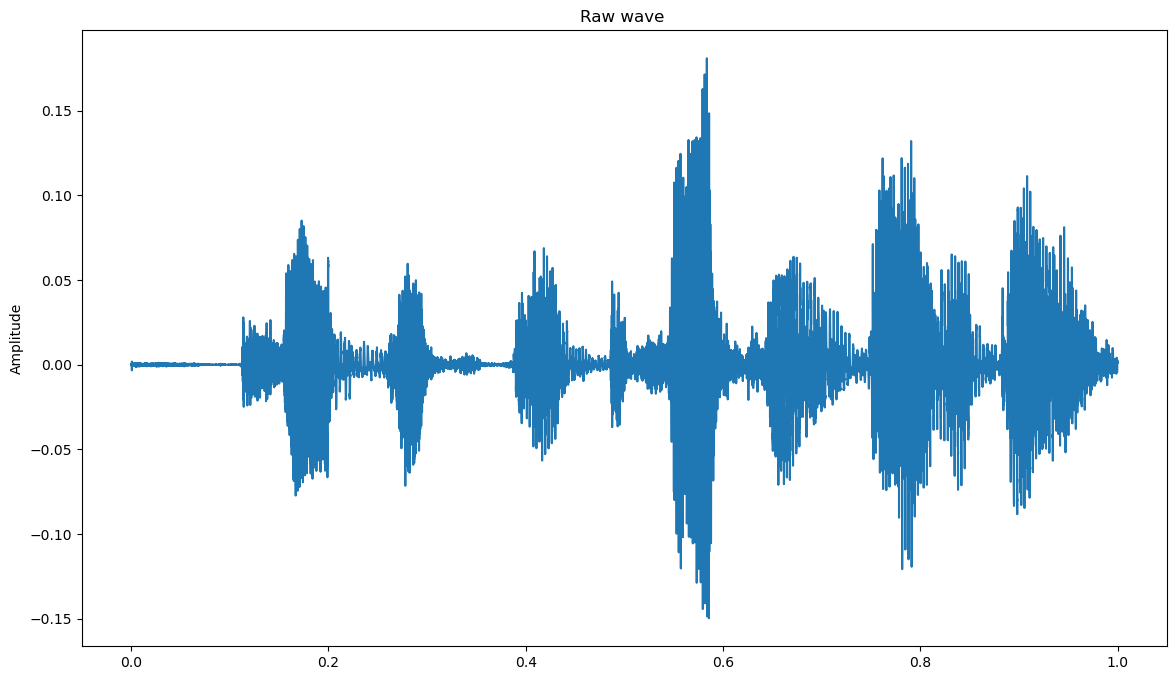

In [14]:
X, sample_rate = librosa.load(chunk_files[0], sr=48000)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

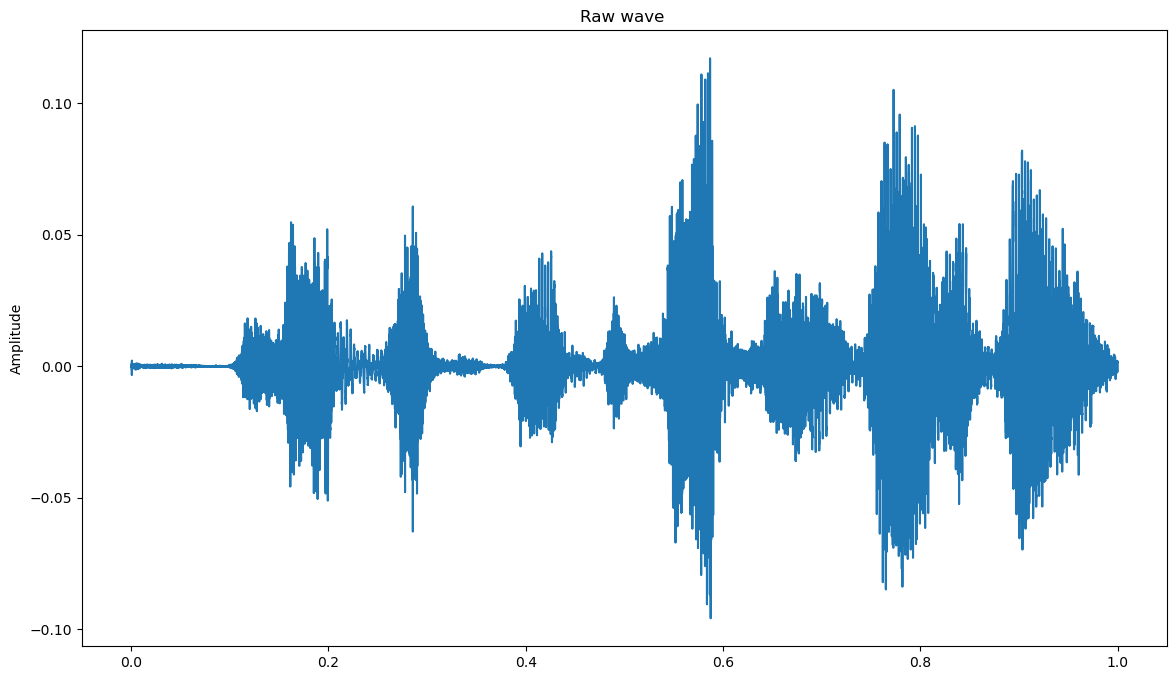

In [15]:
x = pitch(data=X, sample_rate=sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

---

## Audio Framing

In [2]:
import librosa
import numpy as np
import IPython.display as ipd

In [3]:
waveform, sample_rate = librosa.load('test/20240404_102018/Audio/01-01-03-02-01-02-16.wav', sr=None)
ipd.display(ipd.Audio(data=waveform, rate=sample_rate))

In [ ]:
# https://stackoverflow.com/a/66921909

x = np.arange(0, 128)
frame_len, hop_len = 16, 8
frames = librosa.util.frame(x, frame_length=frame_len, hop_length=hop_len)
windowed_frames = np.hanning(frame_len).reshape(-1, 1)*frames

# Print frames
for i, frame in enumerate(frames):
    print("Frame {}: {}".format(i, frame))

# Print windowed frames
for i, frame in enumerate(windowed_frames):
    print("Win Frame {}: {}".format(i, np.round(frame, 3)))

In [41]:
frame_len, hop_len = 48000, 24000
frames = librosa.util.frame(waveform, frame_length=frame_len, hop_length=hop_len, axis=0)
# windowed_frames = np.hanning(frame_len).reshape(-1, 1)*frames

# # Print frames
# for i, frame in enumerate(frames):
#     print("Frame {}: {}".format(i, frame))

# # Print windowed frames
# for i, frame in enumerate(windowed_frames):
#     print("Win Frame {}: {}".format(i, np.round(frame, 3)))

In [42]:
len(frames)

6

In [43]:
for i in frames:
    ipd.display(ipd.Audio(data=i, rate=sample_rate))

---

## Image binarization

In [19]:
from pathlib import Path
import cv2
from display import pltDisplay
import utils

In [9]:
path = str(Path('test/50.jpg'))

In [22]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_bin = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 3
)

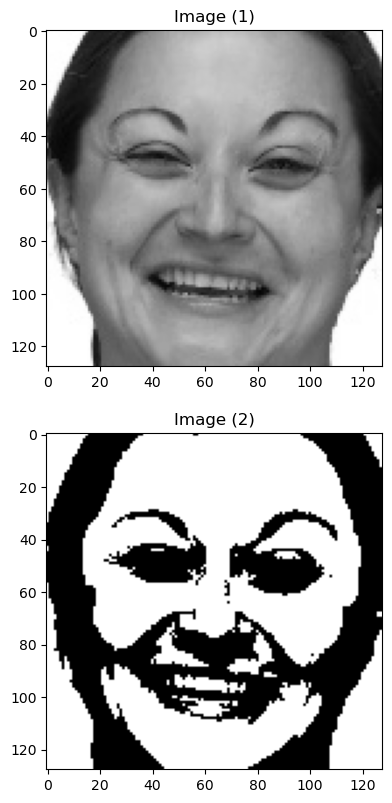

In [23]:
utils.show_images([image, image_bin])

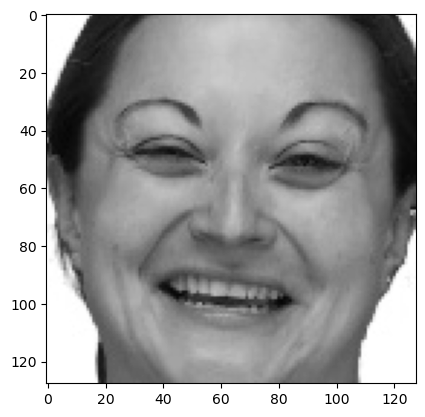

In [18]:
pltDisplay(image)

---

## cifar10 ROC CURVE

In [24]:
import tensorflow as tf
import numpy as np
import utils
from display import pltDisplay
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

x_train = x_train[:1000]
y_train = y_train[:1000]

# train set / data
x_train = x_train.astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

print(x_train.shape, y_train.shape)
# (50000, 32, 32, 3) (50000, 10)


(1000, 32, 32, 3) (1000, 10)


In [35]:
tf.keras.backend.clear_session()

In [36]:
input = tf.keras.Input(shape=(32, 32, 3))
efnet = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                               strides=(1, 1), input_shape=(32, 32, 3),
                               activation='relu')(input)

# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation='softmax')(gap)

# bind all
func_model = tf.keras.Model(input, output)

In [37]:
# Define training callbacks

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='categorical_accuracy',
    verbose=1,
    patience=5,
    restore_best_weights=True
)

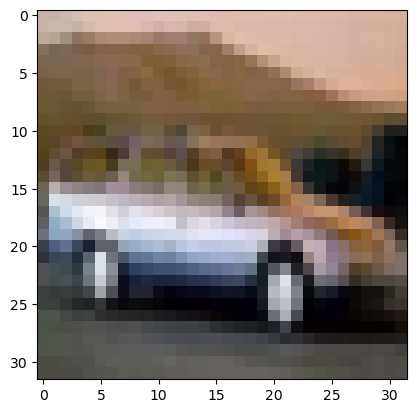

In [33]:
pltDisplay(x_train[4])

In [38]:
time_callback = TimeHistory()
func_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy(),
    optimizer=tf.keras.optimizers.Adam()
)

func_model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=1,
               callbacks=[time_callback, early_stopping_callback])

Epoch 1/100
32/32 [==============================] - 1s 22ms/step - loss: 2.3082 - categorical_accuracy: 0.0890
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 2.2868 - categorical_accuracy: 0.1150
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 2.2762 - categorical_accuracy: 0.1170
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 2.2652 - categorical_accuracy: 0.1610
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 2.2543 - categorical_accuracy: 0.1430
Epoch 6/100
32/32 [==============================] - 1s 17ms/step - loss: 2.2391 - categorical_accuracy: 0.1890
Epoch 7/100
32/32 [==============================] - 1s 17ms/step - loss: 2.2209 - categorical_accuracy: 0.2000
Epoch 8/100
32/32 [==============================] - 1s 16ms/step - loss: 2.2129 - categorical_accuracy: 0.2080
Epoch 9/100
32/32 [==============================] - 1s 17ms/step - loss: 2.1966 - categorical_accuracy:

In [39]:
ypred = func_model.predict(x_train)
ypred = ypred.argmax(axis=-1)

ytrain = y_train.argmax(axis=-1)

32/32 [==============================] - 0s 5ms/step


In [40]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    # function for scoring roc auc score for multi-class
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(
            y_test[:, idx].astype(int),
            y_pred[:, idx]
        )
        c_ax.plot(
            fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr))
        )
    c_ax.plot(fpr, fpr, 'b-', label='Random Guessing')

    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.6055556240021013


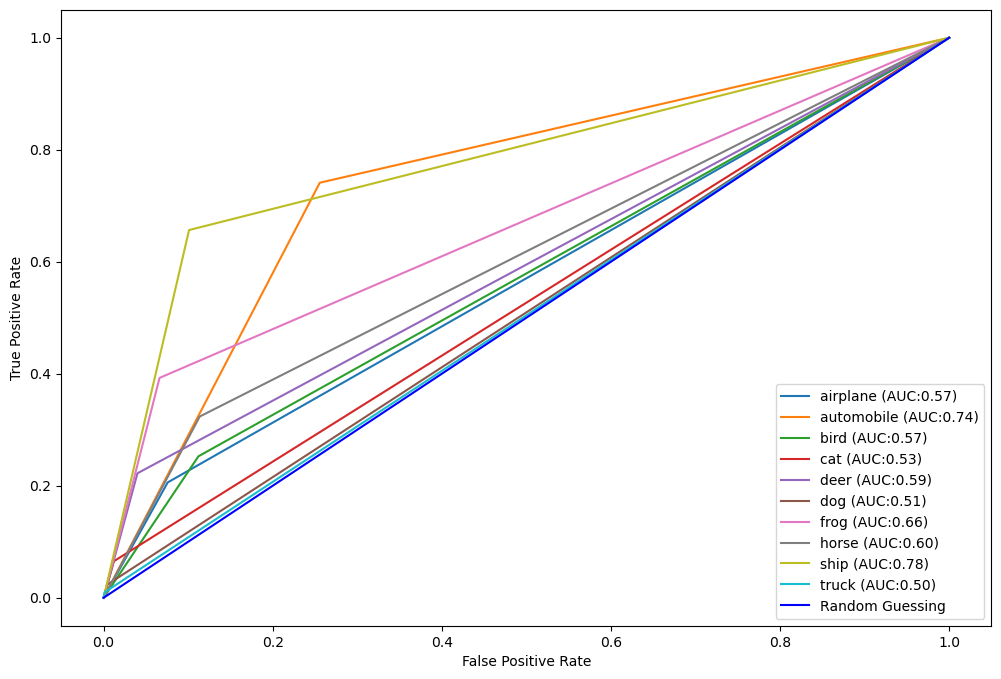

In [41]:
target = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1, 1, figsize=(12, 8))

print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

---

In [4]:
for x in range(1000):
    obj = x * 10

In [6]:
print("C:\\Users\\mic-c\\Documents\\GitHubRepo\\CNN-emotion-recognition\\\
FlowGridSearch\\Run_1\\01-01-02-01-01-02-11\\video_30.mp4")

C:\Users\mic-c\Documents\GitHubRepo\CNN-emotion-recognition\FlowGridSearch\Run_1\01-01-02-01-01-02-11\video_30.mp4


In [5]:
from IPython.display import display, Video

In [13]:
p = "C:\\Users\\mic-c\\Documents\\GitHubRepo\\CNN-emotion-recognition\\FlowGridSearch\\Run_1\\01-01-02-01-01-02-11\\video_30.mp4"

In [17]:
Video('t.mp4')

In [2]:
import cv2
import pandas as pd
import constants as const
from pathlib import Path

In [3]:
df = pd.read_csv(Path(const.csv_path, 'dataset.csv'))

## Flow Generation

In [5]:
OUTPUT_SIZE = [64, 64]
N_FRAMES = 10

# MAX dimensions of bounding box
MAX_WIDTH = 300
MAX_HEIGHT = 300

# Dimensions of generated images
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [6]:
# Optic flow Farneback parameter definitions

DEF_PYR_SCALE = 0.5
DEF_LEVELS = 5
DEF_WINSIZE = 13
DEF_ITERATIONS = 10
DEF_POLY_N = 5
DEF_POLY_SIGMA = 1.1
DEF_FLAGS = 0

PYR_SCALE = 0.7
LEVELS = 10
WINSIZE = 15
ITERATIONS = 3
POLY_N = 30
POLY_SIGMA = 1.5
FLAGS = 0

In [16]:
item = df.iloc[2]
item_path = str(Path(item.path, item.filename))

# Reading a video from file
cap = cv2.VideoCapture(item_path)

# Initialize VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('ok.avi', fourcc, 30, (1280, 720))

while (True):

    # capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    # Write the frame to output file
    out.write(frame)

    # Display a frame
    cv2.imshow('Frame', frame)

    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

# Release the capture objects
out.release()
cap.release()


# Destroy all windows
cv2.destroyAllWindows()

No frames grabbed!


In [24]:
ord('c')

99

In [26]:
term = ord('a')
match term:
    case 97:
        print('a')
    case 98:
        print('b')
    case 99:
        print('c')
    case 0:
        print('not key')

a


In [36]:
ord('o')

111

In [29]:
# Displays image inside a window
cv2.imshow('color image', img_color)


# Waits for a keystroke
key = cv2.waitKey(0)
match key:
    case 97:
        print('a')
    case 98:
        print('b')
    case 99:
        print('c')
    case _:
        print('not key')

# Destroys all the windows created
cv2.destroyAllWindows()

a


## Regex Test

In [1]:
res = "Film annunciati: BERLIN IN BERLIN regia S. Cetin con H. Avsar, C. Ozer, A. Block - turco/red. - G: thriller - C MOTEL EDEN (El Jardin del Eden) regia M. Novara con R. Coleman, B. Bichir, G. Roel - messicano/canade- se - G: avventuroso - C THE ROLY POLY MAN regia B. Young con P. Chubb, L. Foxcroft, S. Lyons - austral. • G: commedia - C MARIE regia M. Handwerker con M. Gillain, A. Sigona, A. Clement, S. Ferrara, S. Leurquin - fr.-belga-portoghese - G: drammatico - C - NO.: n. 89189 del 10/1/94 - L: m. 2420 ROMA- 19-08 (14) 1.225 MILANO 1-09 (!) 760 TORINO GENOVA 2-09 (!) 94 PADOVA BOLOGNA FIRENZE NAPOU BARl CATANIA CAGUARI ANCONA TOT. 3 CAPOZ.: gg. 28 sp. 2.079 L. 20.198.000 TOT.GENERALE gg. 28 sp. 2.079 L. 20.198.000 ao Milli iTTTTTT: Artisti Associati rtftti ttto, Sede centrale: Roma, Via degli Scipioni, 281/283 - Tel. 3210367- Ira 0346 - Fax: 7245 - Presidente: Giuseppe Perugia - Dir. Comm.le: Francesco Brunetti - Ufficio stampa: Rita Nobile/Studio Lapis Film annunciati: DOUN JUAN DE MARCO AND THE CENTERFOLD regia J. Leven con M. Brando, J. Depp -am.-G: dramma- tico - C MEN OF WAR regia P. Lang con D. Lungren - am. - G: drammatico - C SLEEP WITH ME regia R. Kelly con M. Tilly, C. Sheffer, E. Stoltz - am. - G: commedia - C THE PEREZ FAMILY regia M. Nair con M. Tornei, Alfred Molina, A. Huston - am. - G: commedia - u ACE VENTURA: L'ACCHIAPPANIMALI (Ace Ventura: Pet detective) regia T. Shadyac con J. Carrey, S. Young - am.- G: commedia - C - NO.: n. 89666 del 4/8/94 - L: m. 2430 - Dolby Stereo ROMA 26-08 (228) 56.702 MIUNO 25-08 (106) 75.932 TORINO 26-08 (96) 38.434 GENOVA 2608 (61) 18.584 PADOVA 2608 (49) 16.405 BOLOGNA 2608 (82) 25.319 FIRENZE 26-08 (56) 15.144 NAPOU 1-09 52 13.060 BARl 2648 (25) 7.134 CATANIA 2-09 (37) 8.854 CAGLIARI 1-09 (28) 17.010 ANCONA 8-09 (22) 6.117 TOT. 12 CAPOZ.: gg. 842 sp. 298.695 L. 2.855.029.000 ALTRE 85 CIHÀ gg. 1886 sp. 587.168 L 5.500.970.000 TOT.GENERALE gg. 2728 sp. 885.863 L. 8.355.999.000 IL"

In [2]:
import re

In [74]:
movie_title = re.findall(r'(?:- C|- u|:) ((?:[\w]+[\']?[:]?[ ]?[\(|\)]?)+) regia', res)

In [75]:
movie_title

['BERLIN IN BERLIN',
 'MOTEL EDEN (El Jardin del Eden)',
 'THE ROLY POLY MAN',
 'MARIE',
 'DOUN JUAN DE MARCO AND THE CENTERFOLD',
 'MEN OF WAR',
 'SLEEP WITH ME',
 'THE PEREZ FAMILY',
 "ACE VENTURA: L'ACCHIAPPANIMALI (Ace Ventura: Pet detective)"]

---

## Old code Spectrogram Generation

### Metric List

In [ ]:
METRICS = [
    # tf.keras.metrics.SparseCategoricalCrossentropy(),  # same as model's loss
    'accuracy',
    # tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    # tf.keras.metrics.TruePositives(name='tp'),
    # tf.keras.metrics.FalsePositives(name='fp'),
    # tf.keras.metrics.TrueNegatives(name='tn'),
    # tf.keras.metrics.FalseNegatives(name='fn'),
    # tf.keras.metrics.Precision(name='precision'),
    # tf.keras.metrics.Recall(name='recall'),
    # tf.keras.metrics.F1Score(name='F1 score'),
    # f1_metric()
    # tf.keras.metrics.AUC(name='auc'),
    # tf.keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

---